# MS017 Epoching
06/27/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS017'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 87 x 1141024 (2228.6 s), ~757.5 MB, data loaded>

In [26]:
mne_data_reref.drop_channels('research')

<Raw | wm_ref_ieeg.fif, 86 x 1141024 (2228.6 s), ~748.8 MB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 1141024 (2228.6 s), ~8.8 MB, data loaded>

In [27]:
mne_data_reref.save(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif',overwrite=True)

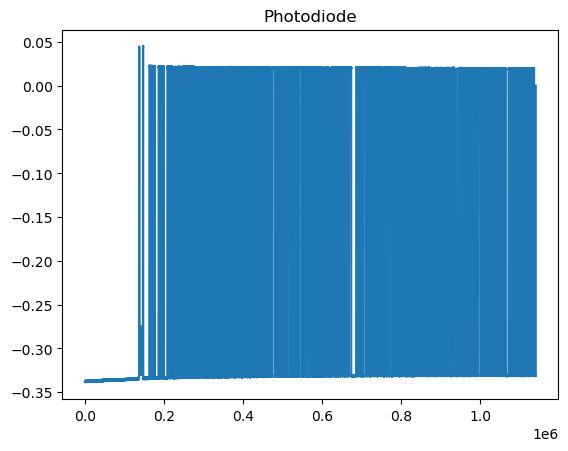

In [8]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [9]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,NMMlabel,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,umOlF,A11m_L,-5.954451,58.308871,-5.446998,-5.251752,52.377382,-19.502634,Gray,Left GRe gyrus rectus,Area Fo1,L Rectal Gyrus,L OrG,Left frontal orbital 2 A,WM,NaN
1,uLAgIT,mAmyg_L,-17.951753,11.146713,-15.841007,-18.630204,-2.284212,-22.591126,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala inferior,NaN,NaN
2,LaCaS1,A32sg_L,-5.954451,37.525547,2.948164,-5.375178,31.113916,-6.133334,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,WM,NaN
3,LaCaS10,A9l_L,-10.353462,45.119454,48.921668,-9.051641,49.423312,46.098305,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 2 C,NaN,NaN
4,LaCaS11,Unknown,-10.753372,46.318492,52.119825,-9.423595,51.602239,49.768326,Unknown,Unknown,Unknown,L Superior Medial Gyrus,Unknown,Left superior frontal gyrus 2 C,OOB,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,LTPlT4,A21r_L,-36.347618,23.536772,-25.835248,-38.966744,9.549138,-35.666432,White,Left TMP temporal pole,Unknown,L Inferior Temporal Gyrus,L MTG,Left superior middle temporal pole D,WM,NaN
106,LTPlT5,A21r_L,-41.146539,23.137092,-25.035708,-44.119363,9.465391,-34.533635,Gray,Left TMP temporal pole,Unknown,L Inferior Temporal Gyrus,L MTG,Left superior middle temporal pole D,Left inferior middle temporal pole C,NaN
107,LTPlT6,A21r_L,-46.345370,22.737413,-23.836399,-49.685882,9.485142,-32.884898,Gray,Left TMP temporal pole,Unknown,L Medial Temporal Pole,L MTG,Left superior middle temporal pole D,NaN,NaN
108,LTPlT7,A21r_L,-50.744381,22.737413,-22.637091,-54.349179,9.952847,-31.341105,Gray,Left TMP temporal pole,Unknown,L Medial Temporal Pole,L MTG,Left superior middle temporal pole D,NaN,NaN


## Load behavior

In [10]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,32.0,mix,118.400476,118.411163,122.335075,124.351936,3.923912,0.0,-1.50,...,-0.846715,0.096301,0.903699,0.846715,0.000000,0.493381,0.000000,0.000000,1.340096,0.493381
1,2,11.0,mix,129.243242,129.252721,131.680515,131.687489,2.427793,0.0,-0.50,...,-0.197281,0.327587,0.672413,0.000000,0.197281,0.197281,0.000000,0.000000,0.197281,0.197281
2,3,58.0,gain,138.569014,138.569721,142.691407,142.699045,4.121686,0.2,0.00,...,0.000000,0.785769,0.214231,0.000000,-0.205088,-0.205088,-0.205088,-0.205088,0.000000,0.000000
3,4,107.0,loss,156.066675,156.074704,160.448116,160.455069,4.373412,-0.2,-0.63,...,-0.268025,0.277568,0.722432,0.000000,-0.117073,-0.117073,-0.117073,-0.117073,0.000000,0.000000
4,5,118.0,loss,167.732757,167.733475,171.742701,171.750382,4.009226,-0.3,-1.08,...,-0.547726,0.099679,0.900321,0.000000,-0.200424,-0.200424,-0.200424,-0.200424,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,116.0,loss,1880.174175,1880.181643,1883.601460,1883.608344,3.419817,-0.3,-0.84,...,-0.392501,0.228437,0.771563,0.000000,0.192077,0.192077,0.000000,0.000000,0.192077,0.192077
146,147,29.0,mix,1890.856264,1890.857010,1893.529529,1893.536447,2.672519,0.0,-1.50,...,-0.846715,0.013837,0.986163,0.000000,-0.173436,-0.173436,-0.173436,-0.173436,0.000000,0.000000
147,148,62.0,gain,1905.140124,1905.147126,1906.989078,1906.996028,1.841952,0.3,0.00,...,0.000000,0.537459,0.462541,0.000000,0.202617,0.202617,0.000000,0.000000,0.202617,0.202617
148,149,66.0,gain,1914.440992,1914.444753,1916.783871,1918.799001,2.339119,0.3,0.00,...,0.000000,0.773902,0.226098,-0.396795,-0.396795,-0.202617,-0.396795,-0.202617,0.000000,0.000000


In [11]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [18]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.5)

10 blocks
..........

found matches for 120 of 160 pulses
8 blocks
........

found matches for 100 of 160 pulses


## Make epochs

In [19]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [20]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [21]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [28]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=2, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 11108 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 12900 out of 12900 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 12476 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 12900 out of 12900 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 task

In [29]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 0.996094 sec, baseline off, ~75.7 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 3.99609 sec, baseline off, ~126.1 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [30]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [31]:
epochs_all_evs[event].metadata

,lmolf3,lacas9,lacas11,lacas12,lmcms5,lmcms9,lmcms10,lalps14,lmlbr5,lmlbr6,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,[436],NaN,NaN,NaN,...,-0.255,1.245,0.00,0.99,0.00,0.00,2.49,0.99,-0.353334,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.26,-0.26,0.00,0.00,0.50,0.50,-0.113482,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.52,-0.52,-0.52,-0.52,0.00,0.00,0.323442,0.118354
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.20,-0.20,-0.20,-0.20,0.00,0.00,-0.268025,-0.117073
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.30,-0.30,-0.30,-0.30,0.00,0.00,-0.547726,-0.200424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,"[519, 697]",NaN,NaN,NaN,...,0.000,0.000,-0.30,-0.30,0.00,0.00,0.54,0.54,-0.392501,-0.200424
146,NaN,NaN,NaN,NaN,NaN,NaN,"[834, 1191]",NaN,NaN,NaN,...,0.000,0.000,-0.45,-0.45,-0.45,-0.45,0.00,0.00,-0.673279,0.000000
147,NaN,NaN,NaN,NaN,NaN,NaN,[602],NaN,NaN,NaN,...,0.000,0.000,-0.25,-0.25,0.00,0.00,0.30,0.30,0.226307,0.202617
148,NaN,NaN,NaN,NaN,NaN,NaN,[415],NaN,NaN,NaN,...,0.420,-0.420,-0.84,-0.30,-0.84,-0.30,0.00,0.00,0.396795,0.202617


### Save epoched data

In [32]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)